In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax_cosmo as jc

import cloudpickle as pickle


def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

def reshape_data(dat):
    realpart = dat[:, ::2, :, :]
    impart = dat[:, 1::2, :, :]

    return jnp.stack([realpart, impart], axis=-1)

# compute MOPED vectors for power spectra

$$ t = \nabla \mu_*^T C^{-1}_* (d - \mu) $$

In [2]:
### ------------- IMNN PARAMETERS -------------
θ_fid = jnp.array([0.3, 0.800]) # CHANGE TO OmegaM=0.6
δθ = 2*jnp.array([0.0115, 0.015])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))

n_summaries = 2

n_s = 1000
n_d = 250

n_params = 2
n_summaries = n_params
print(θ_der)

[[0.2885 0.8   ]
 [0.3    0.785 ]
 [0.3115 0.8   ]
 [0.3    0.815 ]]


In [3]:
0.8 - 0.785, 0.3 - 0.2885

(0.015000000000000013, 0.01150000000000001)

In [4]:
# first load all data
datadir = "/data101/makinen/borg_sunglass/"

import sys,os

folders = ["omegaM", "sigma8", "fiducial", "prior"]
#folders = ["prior"]


def get_fiducial(
                 sim_path = "/data101/makinen/borg_sunglass/fiducial/",
                 data_folder = "/Cls/",
                 num_sims=1000):

    sim_path = sim_path + data_folder

    dir_list = os.listdir(sim_path)[:num_sims]
    
    sim_index = []
    sims = []
    
    for filename in dir_list:
        sim = np.load(sim_path + filename)
        sims.append(sim)
    
    return np.array(sims)


def sort_derivatives(folder, 
                     fiducial_value, 
                     sim_path = "/data101/makinen/borg_sunglass/",
                     data_folder = "/Cls/",
                     num_sims=250):
    
    """load in derivative sims"""

    sim_path = sim_path + folder + data_folder

    dir_list = os.listdir(sim_path)
    
    plus_sim_index = []
    minus_sim_index = []
    
    plus_sims = []
    minus_sims = []
    
    # minus_simnames = []
    if folder == "omegaM":
        idx_startidx = 11
        param_endidx = 10
        
        
    else:
        idx_startidx = 10
        param_endidx = 9

    for filename in dir_list:
        
        sim_index = int(filename[idx_startidx:-4])
        param_value = float(filename[4:param_endidx])
        sim = np.load(sim_path + filename)
        
        if param_value < fiducial_value:
            minus_sim_index.append(sim_index)
            minus_sims.append(sim)
                        
        else:
            plus_sim_index.append(sim_index)
            plus_sims.append(sim)
            
        
    # next SORT the arrays by index and return stacked simulations
    plus_sims = np.array(plus_sims)
    minus_sims = np.array(minus_sims)
    
    plus_sim_index = np.array(plus_sim_index)
    minus_sim_index = np.array(minus_sim_index)
    
    sorted_idx = np.argsort(plus_sim_index)
    plus_sim_index = plus_sim_index[sorted_idx]
    plus_sims = plus_sims[sorted_idx]
    
    sorted_idx = np.argsort(minus_sim_index)
    minus_sim_index = minus_sim_index[sorted_idx]
    minus_sims = minus_sims[sorted_idx]
                
    return minus_sim_index[:num_sims], minus_sims[:num_sims], plus_sim_index[:num_sims], plus_sims[:num_sims]


def get_stacked_derivatives(num_sims=250, n_params=2):
    
    _, om_minus, _, om_plus = sort_derivatives("omegaM", fiducial_value=0.3)
    _, s8_minus, _, s8_plus = sort_derivatives("sigma8", fiducial_value=0.8)
    
    derivative_output = np.zeros((2*n_params*num_sims,) + om_minus.shape[1:])
        
    derivative_output[0::4, ...] = om_minus
    derivative_output[1::4, ...] = s8_minus
    
    derivative_output[2::4, ...] = om_plus
    derivative_output[3::4, ...] = s8_plus
    
        
    
    return derivative_output
    

In [68]:
dervs = get_stacked_derivatives(num_sims=250)[:, 4:, 1] # first idx is the ells
fiducial = get_fiducial(num_sims=2000)[:, 4:, 1]

#dervs *= 1e7
#fiducial *= 1e7

dervs.shape, fiducial.shape

((1000, 60), (1995, 60))

In [69]:
np.save("dervs", dervs)
np.save("fid", fiducial)

In [70]:
pwd

'/home/makinen/repositories/alfi_lensing/sunglass_analysis/moped_notebooks'

In [81]:
import h5py as h5
# pull in another random cosmology from the prior
fname = "/data101/makinen/borg_sunglass/prior/Cls/output_random_0001.npy"

h5fname = "/data80/nporqueres/sims_borg_forward/prior/output_random_0001.h5"

f = h5.File(h5fname, 'r')

# EXTRACT COSMOLOGY
print("extracting cosmology from file")
om_idx = 2
s8_idx = 9

omega_m = f['scalars/cosmo'][:][0][om_idx]
sigma_8 = f['scalars/cosmo'][:][0][s8_idx]
Cls_prior = np.load(fname)


extracting cosmology from file


In [87]:
np.save("priorsim", Cls_prior)

In [83]:
omega_m, sigma_8

(0.24839254574801917, 1.3967363646472082)

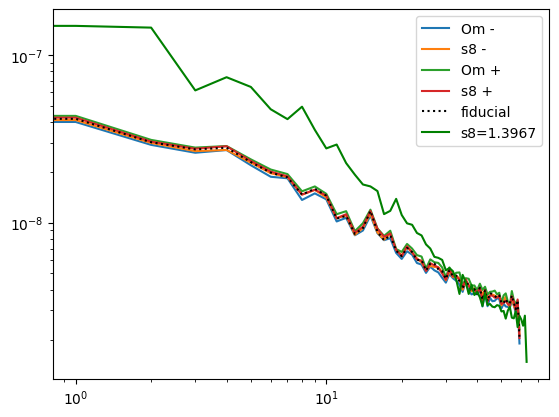

In [86]:
plt.plot(dervs[0], label='Om -')
plt.plot(dervs[1], label='s8 -')

plt.plot(dervs[2], label='Om +')

plt.plot(dervs[3], label='s8 +')

plt.plot(fiducial[0], c='k', ls=':', label='fiducial')

plt.plot(Cls_prior[:, 1], c='green', ls='-', label='s8=1.3967')

plt.loglog()
plt.legend()


In [72]:
# # histogram the spectra
# dervs = jnp.array(dervs)
# fid = jnp.array(fiducial)

# _hist = lambda d: jnp.histogram(d, bins=4)[0]
# dervs = jax.vmap(_hist)(dervs)
# fiducial = jax.vmap(_hist)(fid)


In [73]:
dervs.shape, fiducial.shape

((1000, 60), (1995, 60))

In [74]:
# for m in np.arange(500):
#     if m not in plus_sim_index:
#         print(m)

In [75]:
om_min = 0.2885
om_plus = 0.3115

In [76]:
0.3 - om_min, om_plus - 0.3

(0.01150000000000001, 0.01150000000000001)

In [77]:
### ------------- IMNN PARAMETERS -------------
θ_fid = jnp.array([0.3, 0.800]) # CHANGE TO OmegaM=0.6
δθ = 2*jnp.array([0.0115, 0.015])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))

n_summaries = 2

n_s = 1000
n_d = 250

n_params = 2
n_summaries = n_params
print(θ_der)

[[0.2885 0.8   ]
 [0.3    0.785 ]
 [0.3115 0.8   ]
 [0.3    0.815 ]]


In [78]:
# now get MOPED vector components

full_fid = np.array(fiducial)
full_dervs = np.array(dervs)

n_d = 250
n_s = len(full_fid)

# first inverse covariance 

# get covariance from fiducial sims
C = np.cov(full_fid.reshape(-1, full_fid.shape[-1]), rowvar=False)
invC = np.linalg.inv(C)


mu = np.mean(full_fid, 0)

# next mean of derivatives

# get derivatives
δθ = 2*jnp.array([0.0115, 0.015])
n_param = 2

x_mp = full_dervs.reshape(n_d, 2, n_param, full_dervs.shape[-1])

# compute finite-differences for derivatives
_dervs = (x_mp[:, 1, :, :] - x_mp[:, 0, :, :]) / np.expand_dims(np.expand_dims(δθ, 0), -1)

mu_dervs = np.mean(_dervs, 0)

LinAlgError: Singular matrix

In [51]:
_dervs.shape

(250, 2, 3)

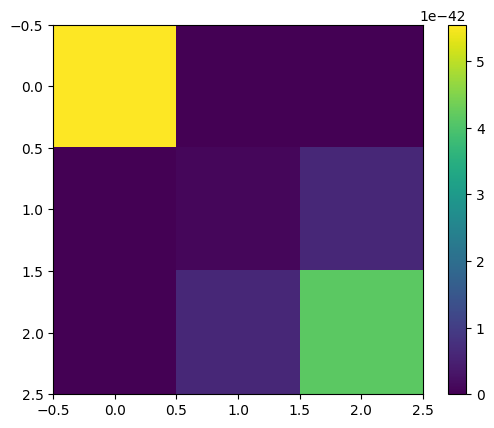

In [52]:
%matplotlib inline

# visualize covariance matrix
plt.imshow((C), vmin=0)
plt.colorbar()

In [53]:
# check that covariance is well-estimated
eigs,evecs = np.linalg.eig(C)
print('minimum eigenvalue', np.min(eigs))
print('maximum eigenvalue', np.max(eigs))

minimum eigenvalue -7.588918514044804e-59
maximum eigenvalue 9.789428944236722e-42


Text(0, 0.5, 'mean derivatives for $C\\ell s$')

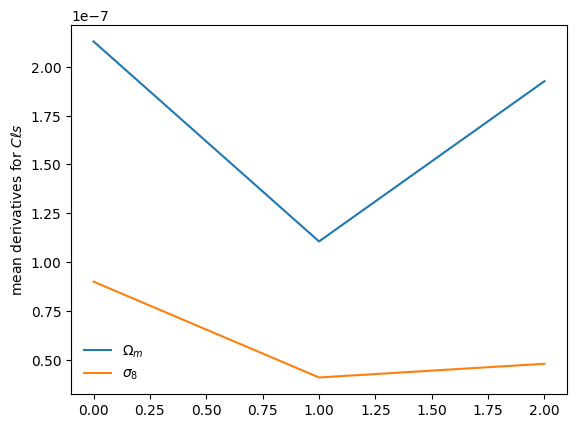

In [54]:
plt.plot(mu_dervs[0, :], label="$\Omega_m$")
plt.plot(mu_dervs[1, :], label=r"$\sigma_8$")
plt.legend(framealpha=0.0)
plt.ylabel("mean derivatives for $C\ell s$")

# bonus: calculate analytic Fisher matrix

In [55]:
F = np.einsum("ij,jl,kl->ik", mu_dervs, invC, mu_dervs)


In [56]:
F

array([[2.03005936e+43, 1.88481365e+42],
       [1.88481365e+42, 1.74995992e+41]])

In [57]:
print("fisher (shannon) information:", 0.5*np.log(np.linalg.det(F)), "nats")

print("fisher (shannon) information:", 0.5*np.log2(np.linalg.det(F)), "bits")

fisher (shannon) information: 87.15584788393114 nats
fisher (shannon) information: 125.73930952662032 bits


In [40]:
np.linalg.inv(F)

array([[2.76062611e-47, 2.19007348e-47],
       [1.75162308e-46, 1.38960623e-46]])

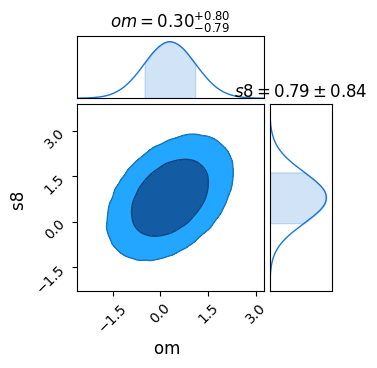

In [467]:
from chainconsumer import ChainConsumer

parameters = ['om', 's8']

Cplot = np.array([[1.82396372e-46,  6.56400190e-46],
         [6.56400190e-46, 3.38146167e-46]]) * 1e45

cs = ChainConsumer()
cs.add_covariance(mean=np.array(θ_fid), covariance = Cplot, parameters=parameters)
cs.configure(usetex=False, serif=False)
cs.plotter.plot()
plt.show()

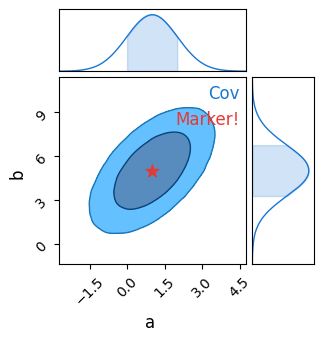

In [419]:
mean = [1, 5]
cov = [[1, 1], [1, 3]]
parameters = ["a", "b"]

c = ChainConsumer()
c.add_covariance(mean, cov, parameters=parameters, name="Cov")
c.add_marker(mean, parameters=parameters, name="Marker!", marker_style="*", marker_size=100, color="r")
c.configure(usetex=False, serif=False)
fig = c.plotter.plot()

# compute summaries over a prior

In [160]:
# now load in all the prior data and compress using the MOPED scheme

X = jnp.load(datadir + "noisefree_prior_sims.npy")[:5000]
y = jnp.load(datadir + "noisefree_prior_params.npy")[:5000]

X = reshape_data(X)


key = jax.random.PRNGKey(8)
keys = jax.random.split(key, num=X.shape[0])
X = jax.vmap(noise_simulator)(keys, X)

X = jax.vmap(field_to_pk)(X)

In [161]:
mu_dervs.shape, invC.shape

((2, 240), (240, 240))

In [162]:
mu_dervs.shape

(2, 240)

In [163]:
# next compress

deltas = (X - mu)

score_vectors = jnp.einsum("mi,ij,jk->mk", mu_dervs, invC, deltas.T).T

In [164]:
max_scores = score_vectors.max()

In [165]:
max_scores

Array(1332.866, dtype=float32)

In [166]:
score_vectors /= max_scores

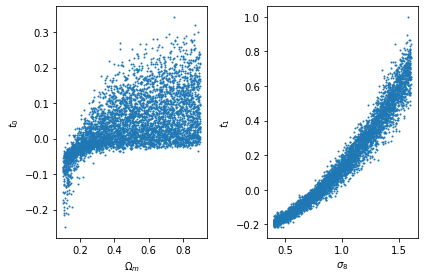

In [167]:
plt.subplot(121)
plt.scatter(y[:, 0], score_vectors[:, 0], s=1)
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$t_0$")

plt.subplot(122)
plt.scatter(y[:, 1], score_vectors[:, 1], s=1)
plt.xlabel(r"$\sigma_8$")
plt.ylabel(r"$t_1$")
plt.tight_layout()

In [140]:
# save score vectors

np.save("/Users/lucas/Datasets/imnn_borg/score_vectors", score_vectors)
np.save("/Users/lucas/Datasets/imnn_borg/score_parameters", y)

In [23]:
# load mock data

#### ------------- get Natalia's target data WITH NOISE -------------
print("loading mock data for obtaining estimates")

import numpy as onp
np = onp
import h5py as h5



def get_data(f):
	dataR = np.zeros((4, 64, 64))
	dataI = np.zeros((4, 64, 64))

	bin0 = f['tomo0'][:]
	bin1 = f['tomo1'][:]
	bin2 = f['tomo2'][:]
	bin3 = f['tomo3'][:]

	data = np.stack([bin0,bin1,bin2,bin3])

	dataR = np.real(data)
	dataI = np.imag(data)

	return dataR, dataI


path = datadir
f = h5.File(path + 'mock_data_fields.h5', 'r')

targetR, targetI = get_data(f)

_dat = onp.ones((8, 64, 64))
_dat[::2, :, :] = targetR
_dat[1::2, :, :] = targetI

np=jnp
_dat = jnp.array(_dat)


target_data = jnp.squeeze(reshape_data(_dat[jnp.newaxis, :, :, :]))

target_data = noise_simulator(jax.random.PRNGKey(99), target_data)

#adjustment = noisevars
#target_data = target_data*(1. / (jnp.sqrt(adjustment).reshape(4, 1, 1, 1)))

loading mock data for obtaining estimates


In [24]:
target_data = field_to_pk(target_data)

In [25]:
delta_target = (target_data - mu)[jnp.newaxis, :]

score_estimates = jnp.einsum("mi,ij,jk->mk", mu_dervs, invC, delta_target.T).T

In [26]:
score_estimates /= max_scores

In [27]:
score_estimates

Array([[-0.00721374, -0.01805398]], dtype=float32)

In [146]:
np.save("/Users/lucas/Datasets/imnn_borg/score_estimates", score_estimates)

In [29]:
# save the components necessary for score compression
np.save("/Users/lucas/Datasets/imnn_borg/moped_pk_dervs", mu_dervs)
np.save("/Users/lucas/Datasets/imnn_borg/moped_pk_mu", mu)
np.save("/Users/lucas/Datasets/imnn_borg/moped_pk_invC", invC)


In [46]:
jnp.log(X +1).min()

Array(-0.0536294, dtype=float32)